# <center><font color='MediumSeaGreen'> _Módulo Machine Learning G45_</font>
# <center><font color='MediumSeaGreen'> Desafío evaluado - Mecanismos de Votación </font>
## <center> _Algoritmo de ensanmble (Parte 2)_ 
    
### <center><b> Bárbara Pérez </b><center>

______________

## <font color='MediumSeaGreen'>Requerimientos</font>

Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o impopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39797 registros, donde cada uno representa características del artículo publicado en el sitio web. Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.. Los artículos registrados son de la página web. Más información sobre los atributos se puede encontrar en el archivo <span style='background:gainsboro'><font color='dimgray'>OnlineNewsPopularity.names</font></span>.

____

## <font color='MediumSeaGreen'>Ejercicio 1: Preparación del ambiente de trabajo</font>

* A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función <span style='background:gainsboro'><font color='dimgray'>grid_plot_batch</font></span> que se encuentra en el archivo <span style='background:gainsboro'><font color='dimgray'>helpers.py</font></span>

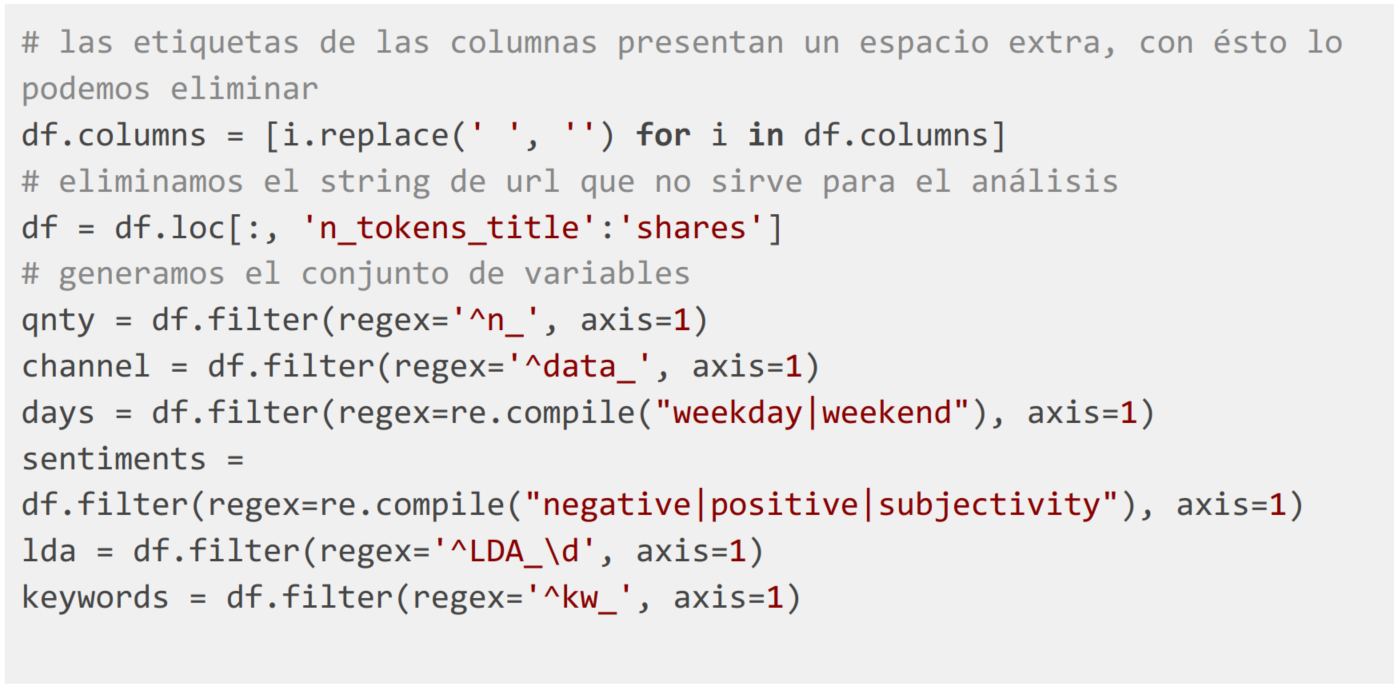

* Describa el comportamiento de las variables.

* Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función <span style='background:gainsboro'><font color='dimgray'>identify_high_correlations</font></span> que se encuentra en el archivo <span style='background:gainsboro'><font color='dimgray'>helpers.py</font></span>. Para todos aquellos atributos que tengan una correlación de .8, reporte sus nombres.

* Antes de generar los conjuntos de entrenamiento y validación, pre procese los datos con los siguientes pasos:

    * Recodifique la variable shares en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable shares posteriormente.
    * Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
    * Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.

In [1]:
# Librerias

#librerías clásicas
import matplotlib.pyplot as plt #version 3.5.2
import pandas as pd  #version 1.4.3
import seaborn as sns  #version 0.11.2
import numpy as np  #version 1.23.0

#Otras librerias
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

import re
import missingno as msngo
import warnings

from helpers import grid_plot_batch
from helpers import identify_high_correlations
from utils import plot_class_report

from IPython.display import display, Markdown

warnings.filterwarnings('ignore')

### Lectura de base de datos

In [2]:
# Importa base de datos

df = pd.read_csv("OnlineNewsPopularity.csv")

# Elimina espacios en nombre columna

df.columns = [i.replace(' ', '') for i in df.columns]

# Elimina columna de url

df.drop(axis="columns", columns=["url"], inplace=True)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      39644 non-null  float64
 1   n_tokens_title                 39644 non-null  float64
 2   n_tokens_content               39644 non-null  float64
 3   n_unique_tokens                39644 non-null  float64
 4   n_non_stop_words               39644 non-null  float64
 5   n_non_stop_unique_tokens       39644 non-null  float64
 6   num_hrefs                      39644 non-null  float64
 7   num_self_hrefs                 39644 non-null  float64
 8   num_imgs                       39644 non-null  float64
 9   num_videos                     39644 non-null  float64
 10  average_token_length           39644 non-null  float64
 11  num_keywords                   39644 non-null  float64
 12  data_channel_is_lifestyle      39644 non-null 

None

### Análisis descriptivo de datos

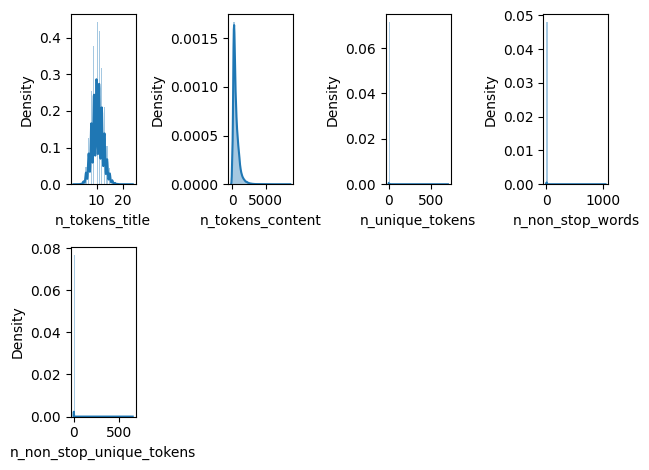

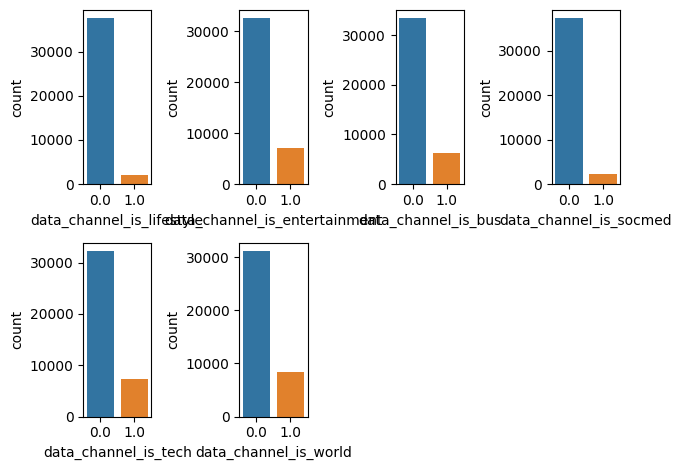

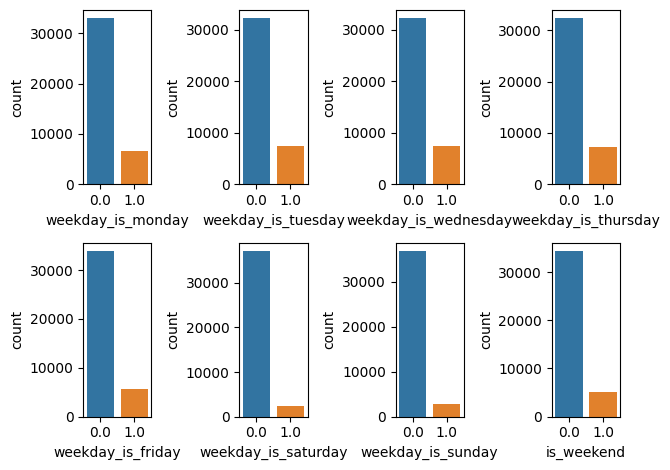

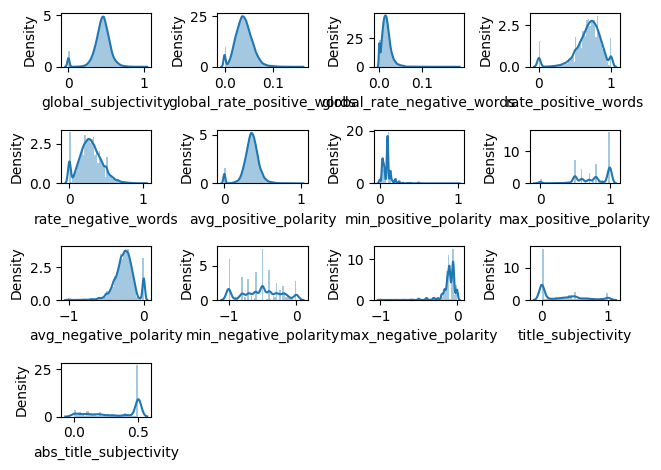

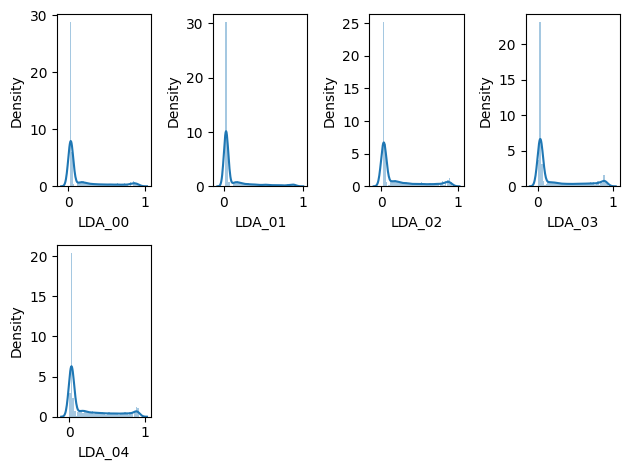

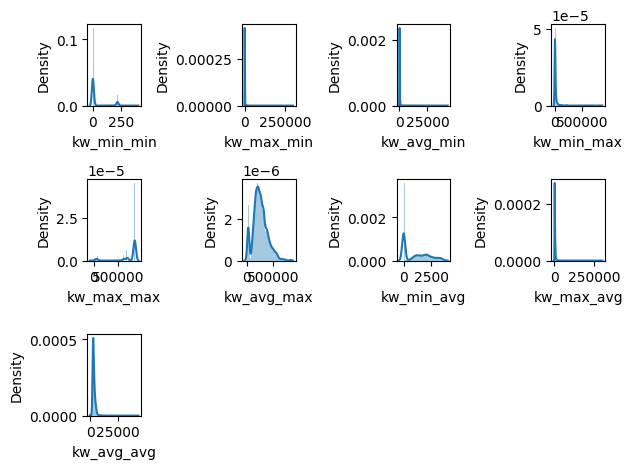

In [3]:
# Genera nuevos dataframes

qnty = df.filter(
    regex='^n_',
    axis="columns"
)

channel = df.filter(
    regex='^data_',
    axis="columns"
)

days = df.filter(
    regex=re.compile("weekday|weekend"),
    axis="columns"
)

sentiments = df.filter(
    regex=re.compile("negative|positive|subjectivity"),
    axis="columns"
)

lda = df.filter(
    regex='^LDA_\d',
    axis="columns"
)

keywords = df.filter(
    regex='^kw_', axis="columns"
)

# Genera un lista de tuplas con variables y tipo de gráfico asociado

variables = [
    (qnty, sns.distplot),
    (channel, sns.countplot),
    (days, sns.countplot),
    (sentiments, sns.distplot),
    (lda, sns.distplot),
    (keywords, sns.distplot)
]

# Genera curvas de densidad y gráficos de barra

cols = 4

for var, plot_type in variables:
    grid_plot_batch(var, cols, plot_type)
    plt.tight_layout()
    plt.show()

### Correlaciones

Se identifican las siguientes correlaciones con valor mayor a 0,8.

In [4]:
high_corr = identify_high_correlations(df, threshold=0.8)
display(high_corr)

,variable,var2,value
243,n_non_stop_words,n_unique_tokens,0.999572
303,n_non_stop_unique_tokens,n_unique_tokens,0.999852
304,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1219,kw_avg_min,kw_max_min,0.940529
1338,kw_max_max,kw_min_min,-0.857226
1585,kw_avg_avg,kw_max_avg,0.811864
1767,self_reference_avg_sharess,self_reference_min_shares,0.818907
1768,self_reference_avg_sharess,self_reference_max_shares,0.853480
2256,is_weekend,weekday_is_sunday,0.701648
2294,LDA_00,data_channel_is_bus,0.774651


### Preprocesamiento

Se recodifica la variable "shares" con 1 para valores mayores a 1400 y 0 de lo contrario. Además, se eliminan una columna del par de variables con alta correlación.

In [5]:
# Recodifica variables shares

df["shares"] = np.where(df["shares"] > 1400, 1, 0)

# Del par de variables con alta correlación se elimina una

df.drop(axis="columns", columns=high_corr["var2"], inplace=True)

### Análisis de componentes principales (PCA)

El análisis de componenten principales permite identificar claramente cuáles son las variables o características que aportan más información, se pueden descartar aquellas menos relevantes, reduciendo así la dimensionalidad del conjunto de datos de trabajo. De esta forma, se simplifica el problema y se agiliza todo el proceso de modelado. (Fuente: https://empresas.blogthinkbig.com/python-para-todos-que-es-el-pca/)

Una de las principales limitaciones de PCA surge cuando los datos están expresados en distintas escalas. Por ello siempre se suele hacer una normalización o estandarización previa. Por otro lado, sólo se consideran transformaciones ortogonales (rotaciones) de las variables originales. Por último, este método asume que los datos siguen una distribución normal o gaussiana. 

#### Estandarización de variables previo a PCA

In [6]:
var_objective = 'shares'
var_attributes = [x for x in df.columns if x != var_objective]

s_scaler = StandardScaler()
X = s_scaler.fit_transform(df.loc[:,var_attributes])
X = pd.DataFrame(X, columns=var_attributes)

display(X.sample(5))

,timedelta,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,global_rate_positive_words,rate_positive_words,rate_negative_words,min_positive_polarity,max_positive_polarity,min_negative_polarity,max_negative_polarity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
33552,-1.179161,0.757447,-0.729173,0.049926,-0.783956,-0.335566,-0.546872,-0.304268,-0.392578,-0.641015,...,0.835552,-0.542591,0.852486,0.573773,-0.228941,-1.646847,-0.838820,-0.269076,0.837749,-0.689658
14213,0.478469,-0.188622,-0.854412,0.014802,-0.519216,0.183228,-0.426526,-0.304268,-0.534131,-0.641015,...,-0.281299,0.794847,-0.776585,1.466113,-1.036100,1.551971,0.378222,0.484370,-0.751332,0.194158
5170,1.323628,-0.188622,-0.707947,0.000229,-0.342723,-0.335566,-0.426526,-0.304268,0.112451,0.406595,...,-0.657306,-0.957658,1.358061,0.573773,-1.036100,0.721509,0.078642,0.571892,-1.420137,0.296824
17143,0.202976,-0.661657,0.682412,-0.003874,0.804484,-0.594963,-0.426526,-0.304268,0.107961,-1.164821,...,1.362097,0.604358,-0.544559,-0.637259,0.981798,0.075594,0.602906,1.614540,-1.810719,1.519883
10509,0.828673,0.284413,0.177213,0.003773,-0.166229,-0.854360,-0.426526,-0.304268,0.157169,0.930401,...,0.458688,-0.230554,0.472410,-0.637259,0.174639,0.075594,0.078642,-0.269076,0.837749,-0.689658


#### Aplicando PCA

In [7]:
# Define nombres de las columnas para los principales componentes

col_names = list(range(30))
col_names = ["comp_" + str(item).zfill(2) for item in col_names]

# Aplica PCA para obtener los principales 30 componentes y almacena datos en nuevo dataframe

pca = PCA(n_components=30)
principal_components = pca.fit_transform(X)

df_pca = pd.DataFrame(
    data=principal_components,
    columns=col_names
)

df_pca = pd.concat([df_pca, df[[var_objective]]], axis = "columns")

display(df_pca.sample(5))

,comp_00,comp_01,comp_02,comp_03,comp_04,comp_05,comp_06,comp_07,comp_08,comp_09,...,comp_21,comp_22,comp_23,comp_24,comp_25,comp_26,comp_27,comp_28,comp_29,shares
3246,0.258341,-3.132005,0.654079,0.047627,-0.908986,1.026881,0.614480,0.280651,-0.095077,0.420664,...,-1.052193,0.287486,0.133933,0.656228,0.553283,0.346124,-0.276884,-0.154368,0.329035,1
37759,-0.281297,1.649125,0.730249,-2.053999,0.148717,-1.070661,-0.129797,0.402851,0.933040,0.358862,...,-0.897135,0.231825,-0.556965,0.553664,-0.454078,-0.813138,-1.261691,0.553973,-0.402379,1
36712,0.725423,0.972944,-1.423442,-0.740445,0.853917,-0.570630,0.110361,-1.424253,0.793195,-0.419439,...,-0.152068,-0.350534,-0.676798,-0.569579,0.524967,-0.520358,-1.225413,-0.447919,-1.093627,0
35581,-0.356602,1.332863,1.691650,-1.087293,0.839748,-1.633046,-0.716166,-2.209490,0.163144,-1.490878,...,-0.166919,-1.132436,-1.013453,0.229849,-1.134522,-0.493317,-0.388748,-0.160459,0.000181,0
21024,-0.983259,-1.624345,-0.012396,0.045573,1.162819,-0.267292,0.887523,-1.291270,-2.276373,0.333945,...,-0.036883,-0.033917,-0.301191,0.660817,0.693858,0.572468,-0.347633,0.217585,-0.414790,0


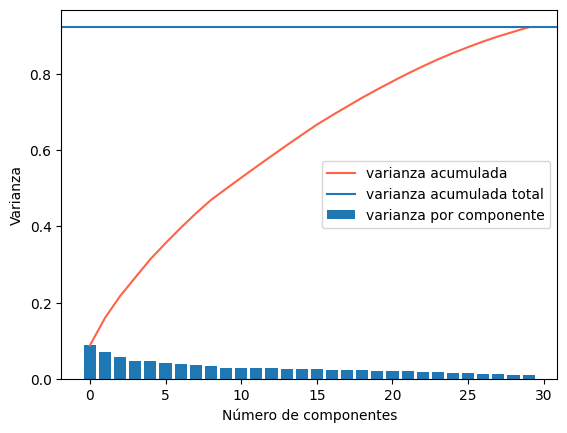

In [8]:
varianza = pca.explained_variance_ratio_

var_acum= np.cumsum(varianza)
plt.bar(range(len(varianza)), varianza, label="varianza por componente")
plt.plot(range(len(varianza)), var_acum, label="varianza acumulada", color="tomato")
plt.axhline(sum(pca.explained_variance_ratio_), label="varianza acumulada total")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza")
plt.legend()
plt.show()

Los nuevos componentes explican más del 90,1% de la varianza de los datos

### División de entrenamiento

In [9]:
var_attributes = [x for x in df_pca.columns if x != var_objective]

X_train, X_test, y_train, y_test = train_test_split(
    df_pca.loc[:, var_attributes],
    df_pca.loc[:,[var_objective]],
    test_size=.33,
    random_state=8643537
)

_________

## <font color='MediumSeaGreen'>Ejercicio 2: Evaluación de modelos individuales</font>

* A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:

    * Importe los módulos correctamente.
    * Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a <span style='background:gainsboro'><font color='dimgray'>Precision</font></span>, <span style='background:gainsboro'><font color='dimgray'>Recall</font></span>, <span style='background:gainsboro'><font color='dimgray'>F1</font></span>. Puede hacer uso de la función <span style='background:gainsboro'><font color='dimgray'>plot_classification_report</font></span> disponible en el archivo <span style='background:gainsboro'><font color='dimgray'>helpers.py</font></span>.
    * Comente el desempeño general de cada uno.
    
* La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    * Regresión Logística.
    * Algoritmo de SVC.
    * Árbol de Clasificación con un <span style='background:gainsboro'><font color='dimgray'>max_depth=<font color='Maroon'>1</font></span>.
    * Árbol de Clasificación con un <span style='background:gainsboro'><font color='dimgray'>max_depth=<font color='Maroon'>4</font></span>.

### Métricas de modelos individuales

In [10]:
rep_seed = 42145

# Define estimadores

estimators = [
    ( "Logistic Regression",LogisticRegression(random_state=rep_seed)),
    ("Super Vector Machine",SVC(random_state=rep_seed)),
    ("Decision Tree Classifier Max Depth 1",DecisionTreeClassifier(random_state=rep_seed, max_depth=1)),
    ("Decision Tree Classifier Max Depth 4",DecisionTreeClassifier(random_state=rep_seed, max_depth=4)
    )
]

,0,1,accuracy,macro avg,weighted avg
precision,0.647449,0.634344,0.641137,0.640896,0.641050
recall,0.655863,0.625704,0.641137,0.640784,0.641137
f1-score,0.651629,0.629994,0.641137,0.640812,0.641065
support,6695.000000,6388.000000,0.641137,13083.000000,13083.000000


,0,1,accuracy,macro avg,weighted avg
precision,0.649404,0.652904,0.650997,0.651154,0.651113
recall,0.691113,0.608954,0.650997,0.650034,0.650997
f1-score,0.669609,0.630164,0.650997,0.649886,0.650349
support,6695.000000,6388.000000,0.650997,13083.000000,13083.000000


,0,1,accuracy,macro avg,weighted avg
precision,0.571495,0.602447,0.582129,0.586971,0.586608
recall,0.733084,0.423920,0.582129,0.578502,0.582129
f1-score,0.642282,0.497657,0.582129,0.569970,0.571666
support,6695.000000,6388.000000,0.582129,13083.000000,13083.000000


,0,1,accuracy,macro avg,weighted avg
precision,0.622785,0.583475,0.60162,0.603130,0.603591
recall,0.561763,0.643394,0.60162,0.602578,0.601620
f1-score,0.590702,0.611971,0.60162,0.601337,0.601087
support,6695.000000,6388.000000,0.60162,13083.000000,13083.000000


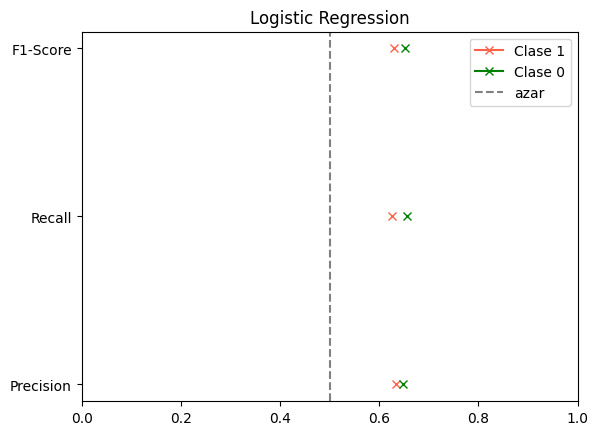

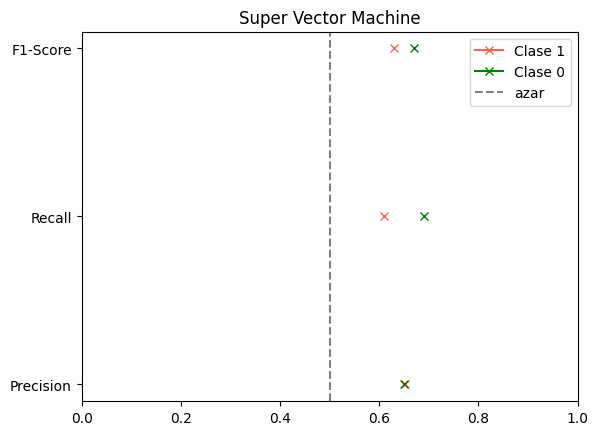

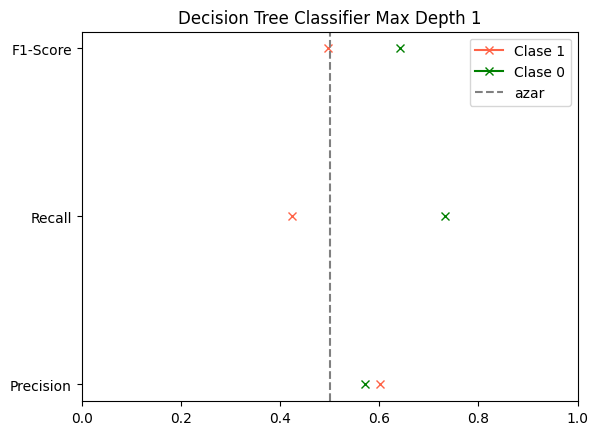

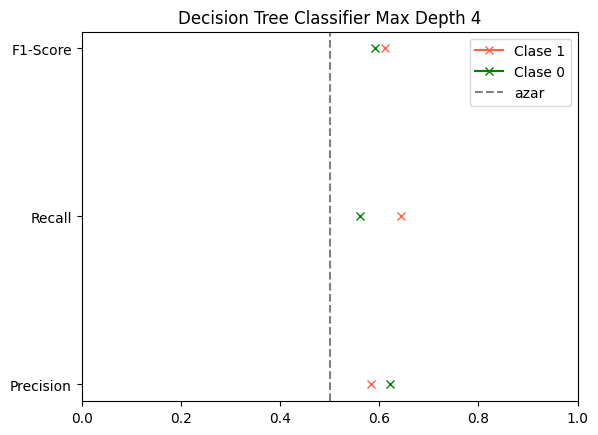

In [11]:
# Grafica métricas para cada estimador

for index, value in enumerate(estimators):
    model = value[1].fit(X_train, y_train)
    class_pred = model.predict(X_test)
    class_report = classification_report(y_test, class_pred, output_dict=True)
    class_report = pd.DataFrame(class_report)

    display(class_report)

    plot_class_report(class_report, title=value[0])

### Comentarios de métricas
1. Todos los estimadores consiguen ser mejores con una clasificación al azar, a excepción de K-Means. 
2. 3 de los 4 modelos tienen métricas similares.
2. El mejor desempeño se lo lleva la regresión logística con todas sus métricas sobre el 60%.

_________

## <font color='MediumSeaGreen'>Ejercicio 3: Entrenamiento de Comité</font>

* Entrene el comité de clasificadores sin modificar el esquema de votación.
* Reporte el desempeño a nivel de cada clase para cada métrica.

[LogisticRegression(random_state=42145),
 SVC(random_state=42145),
 DecisionTreeClassifier(max_depth=1, random_state=42145),
 DecisionTreeClassifier(max_depth=4, random_state=42145)]

,0,1,accuracy,macro avg,weighted avg
precision,0.618261,0.658653,0.6338,0.638457,0.637983
recall,0.743391,0.518942,0.6338,0.631166,0.633800
f1-score,0.675076,0.580510,0.6338,0.627793,0.628902
support,6695.000000,6388.000000,0.6338,13083.000000,13083.000000


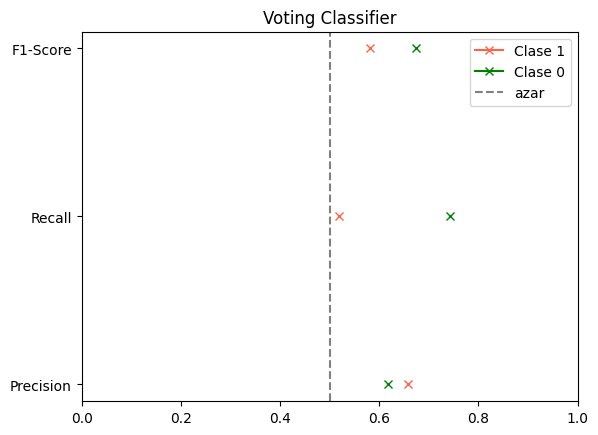

In [12]:
model_vot = VotingClassifier(estimators, voting="hard").fit(X_train, y_train)
voting_classifier_pred = model_vot.predict(X_test)
display(model_vot.estimators_)

class_report_vot = classification_report(
    y_test, voting_classifier_pred, 
    output_dict=True
)
class_report_vot = pd.DataFrame(class_report_vot)

display(class_report_vot)

plot_class_report(class_report_vot, title="Voting Classifier")

Todas las métricas tienden al promedio de los tres mejores clasificadores: logistic regression y decision tree.

________

## <font color='MediumSeaGreen'>Ejercicio 4: Calibración de Comité con Ponderadores</font>

* En base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
* Reporte el desempeño del mejor ensamble heterogéneo

### Propuestas de esquemas

1. **Equiprobabilidad:** Este esquema repetirá el esquema anterior, con la misma podenración para todos los modelos.
2. **Disminución/SVC:** Este esquema disminuirá la ponderación del estimador SVC.
3. **Aumento/SVC:** Este esquema aumentará la ponderación del estimador SVC.
4. **Aumento/LogisticRegression**: Este matendrá la disminución de la ponderación del estimador K-means (punto 2) y aumentará la ponderación del estimador Logistic Regression.

Text(0.5, 1.0, 'Esquema de Ponderación')

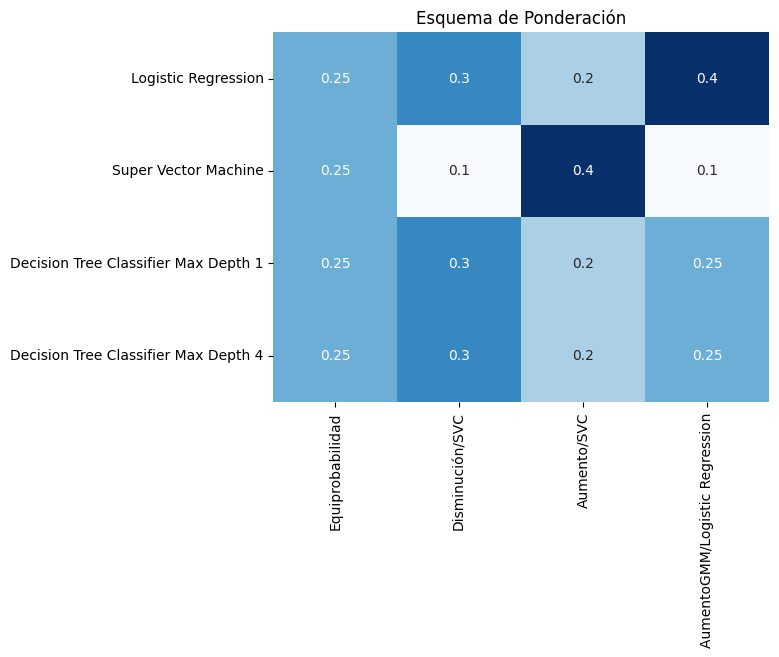

In [13]:
weights_hyperparams = {
    'Equiprobabilidad': [.25, .25, .25, .25],
    'Disminución/SVC': [.3, .1, .3, .3],
    'Aumento/SVC': [.2, .4, .2, .2],
    'AumentoGMM/Logistic Regression': [.4, .1, .25, .25]
}

weights = pd.DataFrame(weights_hyperparams, index=[i[0] for i in estimators])

sns.heatmap(weights, annot=True, cmap='Blues', cbar=False)
plt.title("Esquema de Ponderación")


### Desempeño

**Equiprobabilidad**

,0,1,accuracy,macro avg,weighted avg
precision,0.618261,0.658653,0.6338,0.638457,0.637983
recall,0.743391,0.518942,0.6338,0.631166,0.633800
f1-score,0.675076,0.580510,0.6338,0.627793,0.628902
support,6695.000000,6388.000000,0.6338,13083.000000,13083.000000


**Disminución/SVC**

,0,1,accuracy,macro avg,weighted avg
precision,0.627714,0.621733,0.624933,0.624723,0.624794
recall,0.656311,0.592048,0.624933,0.624179,0.624933
f1-score,0.641694,0.606527,0.624933,0.624111,0.624523
support,6695.000000,6388.000000,0.624933,13083.000000,13083.000000


**Aumento/SVC**

,0,1,accuracy,macro avg,weighted avg
precision,0.646777,0.647981,0.647329,0.647379,0.647365
recall,0.684839,0.608015,0.647329,0.646427,0.647329
f1-score,0.665264,0.627362,0.647329,0.646313,0.646758
support,6695.000000,6388.000000,0.647329,13083.000000,13083.000000


**AumentoGMM/Logistic Regression**

,0,1,accuracy,macro avg,weighted avg
precision,0.625470,0.638411,0.631048,0.631941,0.631789
recall,0.695444,0.563557,0.631048,0.629501,0.631048
f1-score,0.658604,0.598653,0.631048,0.628628,0.629332
support,6695.000000,6388.000000,0.631048,13083.000000,13083.000000


<Figure size 640x480 with 0 Axes>

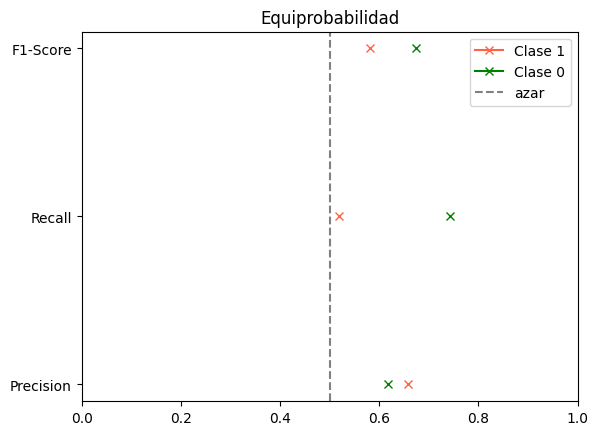

<Figure size 640x480 with 0 Axes>

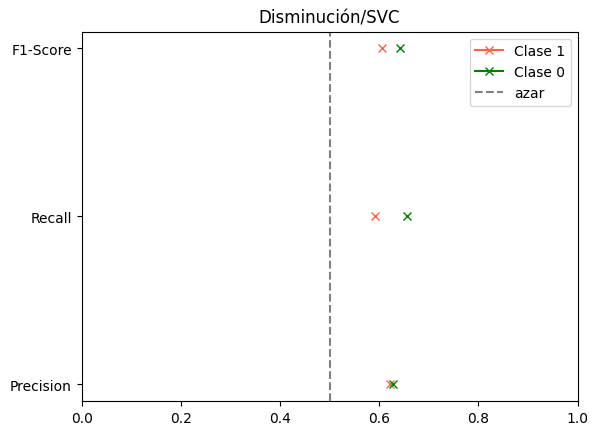

<Figure size 640x480 with 0 Axes>

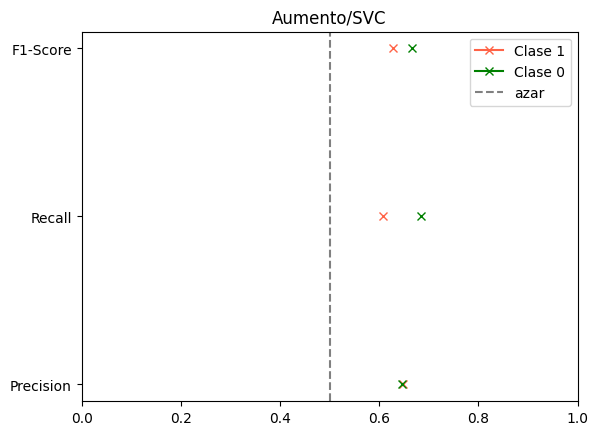

<Figure size 640x480 with 0 Axes>

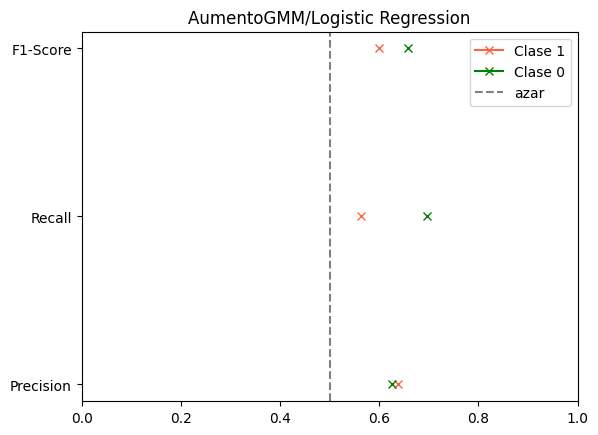

In [14]:
for esquema in weights:

    model_vot = VotingClassifier(
        estimators,
        weights=weights[esquema]
    ).fit(X_train, y_train)


    voting_classifier_pred = model_vot.predict(X_test)

    class_report_vot = classification_report(
        y_test,
        voting_classifier_pred,
        output_dict=True
    )

    class_report_vot = pd.DataFrame(class_report_vot)

    display(Markdown("**" + esquema + "**"))
    display(class_report_vot)

    plt.figure()
    plot_class_report(class_report_vot, title=esquema)

__________